### Setup

In [44]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Seaborn base theme
sns.set_theme(
    context="paper",  # 'paper' = smaller, for journal figures
    style="whitegrid",  # clean background with subtle grid
    font="DejaVu Sans",  # use a consistent sans-serif (replace if needed)
    font_scale=1.4,  # scale up text a bit for readability
    rc={
        # Figure sizing
        "figure.figsize": (4, 3),  # in inches; adjust for single-column
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.linewidth": 1.0,
        "axes.labelpad": 8,
        "axes.grid": True,
        "grid.linewidth": 0.4,
        "grid.alpha": 0.6,
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.frameon": False,
        "savefig.dpi": 300,
        "savefig.transparent": True,  # transparent background for vector exports
        "pdf.fonttype": 42,  # embed TrueType fonts (important for Illustrator)
        "ps.fonttype": 42,
    },
)

# Matplotlib tight layout by default
plt.rcParams.update({"figure.autolayout": True})

In [25]:
ANN_DATA_DIR = "../data/processed/anndata_combined"

human_adata = ad.read_h5ad("../data/processed/anndata_combined/human_combined.h5ad")
mouse_adata = ad.read_h5ad("../data/processed/anndata_combined/mouse_combined.h5ad")

N_SPLITS = 10

### Run PCA on mouse raw data

/tmp/ipykernel_1865861/2127255629.py:16: ImplicitModificationWarning: Setting element `.obsm['X_pca_raw']` of view, initializing view as actual.
  adata_sub.obsm['X_pca_raw'] = X_pca


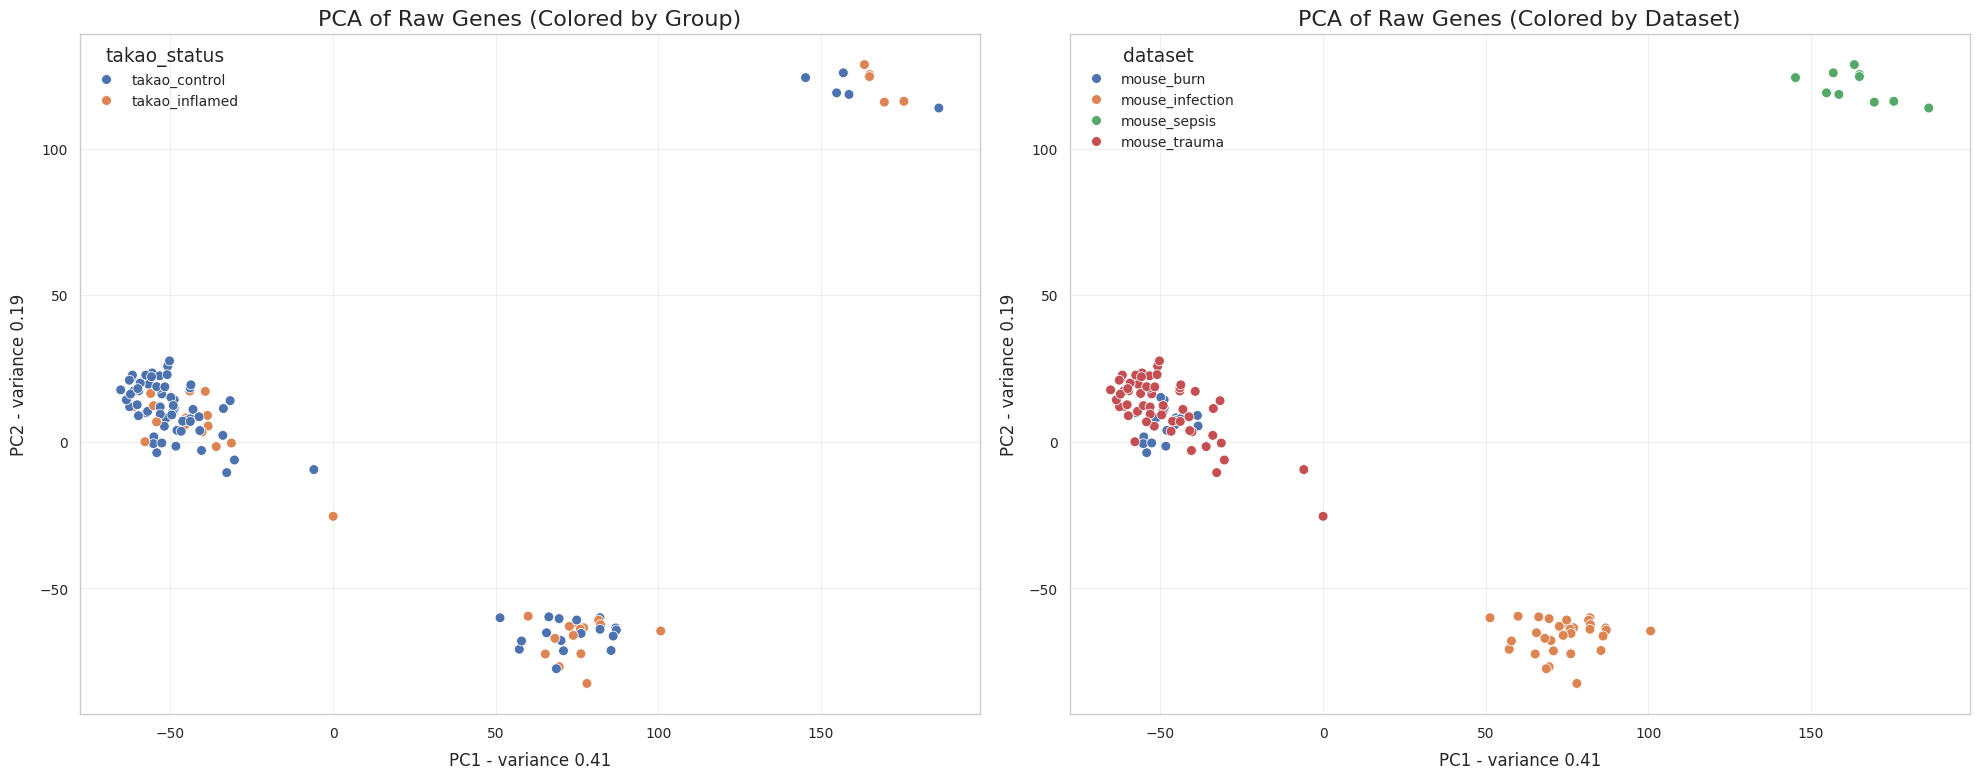

In [26]:
def run_pca_and_plot(adata):
    adata_sub = adata[~adata.obs["takao_status"].isna()]

    # Scale raw data first
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy="constant", fill_value=0)
    X_raw_scaled = scaler.fit_transform(adata_sub.X)
    X_raw_scaled = imputer.fit_transform(X_raw_scaled)

    # Run PCA
    pca = PCA(n_components=2)

    X_pca = pca.fit_transform(X_raw_scaled)

    # Add to our anndata for easy plotting
    adata_sub.obsm["X_pca_raw"] = X_pca
    adata_sub.obs["PC1"] = X_pca[:, 0]
    adata_sub.obs["PC2"] = X_pca[:, 1]

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Colored by Group
    sns.scatterplot(data=adata_sub.obs, x="PC1", y="PC2", hue="takao_status", ax=ax1, s=50)
    ax1.set_xlabel(f"PC1 - variance {pca.explained_variance_ratio_[0]:.2f}")
    ax1.set_ylabel(f"PC2 - variance {pca.explained_variance_ratio_[1]:.2f}")
    ax1.set_title("PCA of Raw Genes (Colored by Group)", fontsize=16)

    # Plot 2: Colored by Batch
    sns.scatterplot(data=adata_sub.obs, x="PC1", y="PC2", hue="dataset", ax=ax2, s=50)
    ax2.set_xlabel(f"PC1 - variance {pca.explained_variance_ratio_[0]:.2f}")
    ax2.set_ylabel(f"PC2 - variance {pca.explained_variance_ratio_[1]:.2f}")
    ax2.set_title("PCA of Raw Genes (Colored by Dataset)", fontsize=16)

    plt.tight_layout()
    plt.show()


run_pca_and_plot(mouse_adata)

### Transform to X, y for model training

In [27]:
def transform_adata_to_X_y(adata):
    adata_sub = adata[~adata.obs["takao_status"].isna()]
    X = adata_sub.X.toarray()
    X_emb = adata_sub.obsm["X_bulkformer"].toarray()
    # set y to 1 for inflamed, 0 for healthy
    y = (
        adata_sub.obs["takao_status"]
        .map({"takao_inflamed": 1, "takao_control": 0})
        .values.astype(int)
    )
    return X, X_emb, y

In [28]:
human_X, human_X_emb, human_y = transform_adata_to_X_y(human_adata)
mouse_X, mouse_X_emb, mouse_y = transform_adata_to_X_y(mouse_adata)

In [29]:
human_X.shape, human_X_emb.shape, human_y.shape, mouse_X.shape, mouse_X_emb.shape, mouse_y.shape

((200, 19914), (200, 640), (200,), (121, 13833), (121, 640), (121,))

### Define pipelines

In [30]:
pipeline_raw = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("clf", LogisticRegression(solver="liblinear", random_state=42)),
    ]
)

pipeline_emb = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(solver="liblinear", random_state=42)),
    ]
)

### Cross-validation on mouse-datasets

In [31]:
def run_cross_val(pipeline, X, y, n_splits=10):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores


# Run cross-validation for each pipeline
scores_raw = run_cross_val(pipeline_raw, mouse_X, mouse_y)
scores_emb = run_cross_val(pipeline_emb, mouse_X_emb, mouse_y)

# We use Wilcoxon signed-rank test (non-parametric, does not assume normality)
_, p = wilcoxon(scores_raw, scores_emb, alternative="two-sided")

print(f"Raw Genes AUROC: {scores_raw.mean():.4f} +/- {scores_raw.std():.4f}")
print(f"Embedding AUROC: {scores_emb.mean():.4f} +/- {scores_emb.std():.4f}")
print(f"Information Preservation (Raw vs. Embedded): p-value = {p:.4f}")

Raw Genes AUROC: 0.9727 +/- 0.0325
Embedding AUROC: 0.9690 +/- 0.0293
Information Preservation (Raw vs. Embedded): p-value = 1.0000


/tmp/ipykernel_1865861/3702462237.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


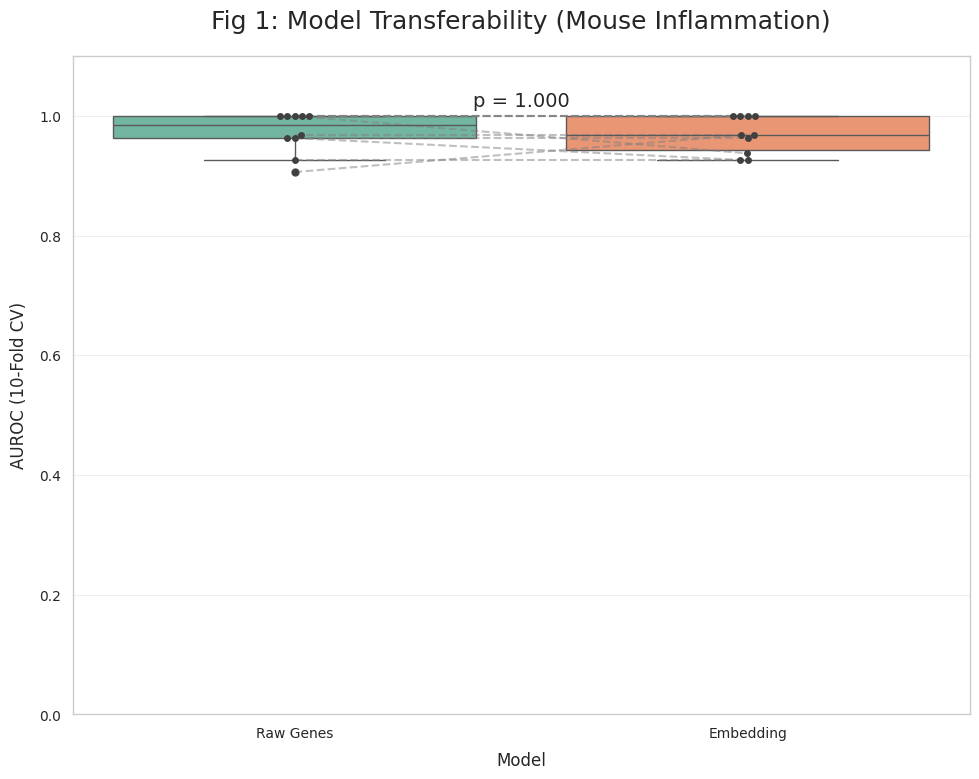

In [32]:
# Create a DataFrame for easy plotting with seaborn
df_list = []
for i in range(N_SPLITS):
    df_list.append({"fold": i, "AUROC": scores_raw[i], "Model": "Raw Genes"})
    df_list.append({"fold": i, "AUROC": scores_emb[i], "Model": "Embedding"})

results_df = pd.DataFrame(df_list)

# Plot
plt.figure(figsize=(10, 8))

# Boxplot
sns.boxplot(data=results_df, x="Model", y="AUROC", palette="Set2")

# Overlay swarmplot (the individual points)
sns.swarmplot(data=results_df, x="Model", y="AUROC", color="0.25")

# Draw the lines connecting paired folds
for i in range(N_SPLITS):
    fold_data = results_df[results_df["fold"] == i]
    plt.plot(fold_data["Model"], fold_data["AUROC"], color="gray", linestyle="--", alpha=0.5)

# Add annotations for p-values
y_max = results_df["AUROC"].max()
plt.text(0.5, y_max + 0.01, f"p = {p:.3f}", ha="center", va="bottom", fontsize=14)

plt.title("Fig 1: Model Transferability (Mouse Inflammation)", fontsize=18, pad=20)
plt.ylabel("AUROC (10-Fold CV)")
plt.ylim(bottom=0, top=1.1)  # Adjust y-axis to make space
plt.tight_layout()

# Save the figure
# plt.savefig("figure_1_transferability.png", dpi=300)
plt.show()

### Leave-one-dataset-out validation on mouse datasets

In [33]:
mouse_sub = mouse_adata[~mouse_adata.obs["takao_status"].isna()]
datasets = mouse_sub.obs["dataset"]
unique_datasets = datasets.unique()

unique_datasets

['mouse_burn', 'mouse_infection', 'mouse_sepsis', 'mouse_trauma']
Categories (4, object): ['mouse_burn', 'mouse_infection', 'mouse_sepsis', 'mouse_trauma']

In [34]:
# Store results here
scores_raw = []
scores_emb = []
fold_names = []

for test_dataset in unique_datasets:
    print(f"--- FOLD: Holding out '{test_dataset}' ---")
    fold_names.append(test_dataset)

    # Create train/test masks
    test_mask = datasets == test_dataset
    train_mask = ~test_mask

    # --- Create Train/Test Splits ---
    # Raw Genes
    X_raw_train, X_raw_test = mouse_X[train_mask], mouse_X[test_mask]
    # Embeddings
    X_emb_train, X_emb_test = mouse_X_emb[train_mask], mouse_X_emb[test_mask]
    # Labels
    y_train, y_test = mouse_y[train_mask], mouse_y[test_mask]

    # --- Train and Score Raw ---
    pipeline_raw.fit(X_raw_train, y_train)
    y_pred_raw_nl = pipeline_raw.predict_proba(X_raw_test)[:, 1]
    scores_raw.append(roc_auc_score(y_test, y_pred_raw_nl))

    # --- Train and Score Embedding (Linear) ---
    pipeline_emb.fit(X_emb_train, y_train)
    y_pred_emb_lin = pipeline_emb.predict_proba(X_emb_test)[:, 1]
    scores_emb.append(roc_auc_score(y_test, y_pred_emb_lin))

print("\n--- LODO-CV Mean Scores ---")
print(f"Raw Genes AUROC:       {np.mean(scores_raw):.4f} +/- {np.std(scores_raw):.4f}")
print(f"Embedding AUROC:       {np.mean(scores_emb):.4f} +/- {np.std(scores_emb):.4f}")

--- FOLD: Holding out 'mouse_burn' ---
--- FOLD: Holding out 'mouse_infection' ---
--- FOLD: Holding out 'mouse_sepsis' ---
--- FOLD: Holding out 'mouse_trauma' ---

--- LODO-CV Mean Scores ---
Raw Genes AUROC:       0.8983 +/- 0.0874
Embedding AUROC:       0.8589 +/- 0.1419


Information Preservation: p-value = 0.7500


/tmp/ipykernel_1865861/822495641.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Model', y='AUROC', palette='Set2')


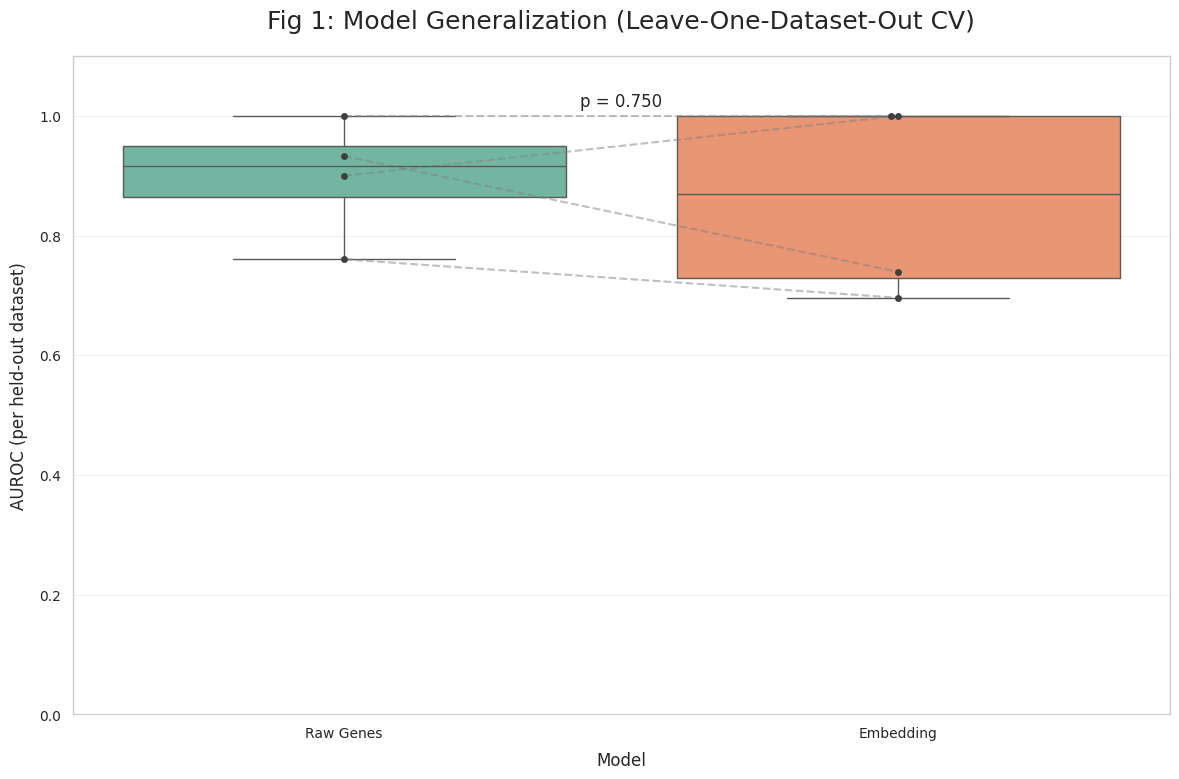

In [35]:
_, p = wilcoxon(scores_raw, scores_emb, alternative="two-sided")

print(f"Information Preservation: p-value = {p:.4f}")

# 2. Create DataFrame for plotting
df_list = []
for i, fold_name in enumerate(fold_names):
    df_list.append({"fold": fold_name, "AUROC": scores_raw[i], "Model": "Raw Genes"})
    df_list.append({"fold": fold_name, "AUROC": scores_emb[i], "Model": "Embedding"})

results_df = pd.DataFrame(df_list)

# 3. Plot
plt.figure(figsize=(12, 8))

# Boxplot
sns.boxplot(data=results_df, x="Model", y="AUROC", palette="Set2")
# Swarmplot
sns.swarmplot(data=results_df, x="Model", y="AUROC", color="0.25")

# Draw the lines connecting paired folds
for fold_name in fold_names:
    fold_data = results_df[results_df["fold"] == fold_name]
    plt.plot(fold_data["Model"], fold_data["AUROC"], color="gray", linestyle="--", alpha=0.5)

# Add annotations
y_max = results_df["AUROC"].max()
plt.text(0.5, y_max + 0.01, f"p = {p:.3f}", ha="center", va="bottom", fontsize=12)
plt.title("Fig 1: Model Generalization (Leave-One-Dataset-Out CV)", fontsize=18, pad=20)
plt.ylabel("AUROC (per held-out dataset)")
plt.ylim(bottom=0, top=1.1)
plt.tight_layout()

plt.show()

The above proves the embedding is valid. The human-trained BulkFormer successfully captured all the linearly-separable biological variance from the mouse gene data. No information relevant to the phenotype was lost.

### Validation on human datasets

In [36]:
def run_cross_val(pipeline, X, y, n_splits=10):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores


# Run cross-validation for each pipeline
scores_raw = run_cross_val(pipeline_raw, human_X, human_y)
scores_emb = run_cross_val(pipeline_emb, human_X_emb, human_y)

# We use Wilcoxon signed-rank test (non-parametric, does not assume normality)
_, p = wilcoxon(scores_raw, scores_emb, alternative="two-sided")

print(f"Raw Genes AUROC: {scores_raw.mean():.4f} +/- {scores_raw.std():.4f}")
print(f"Embedding AUROC: {scores_emb.mean():.4f} +/- {scores_emb.std():.4f}")
print(f"Information Preservation (Raw vs. Embedded): p-value = {p:.4f}")

Raw Genes AUROC: 1.0000 +/- 0.0000
Embedding AUROC: 0.9850 +/- 0.0269
Information Preservation (Raw vs. Embedded): p-value = 0.1250


/tmp/ipykernel_1865861/2367872192.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


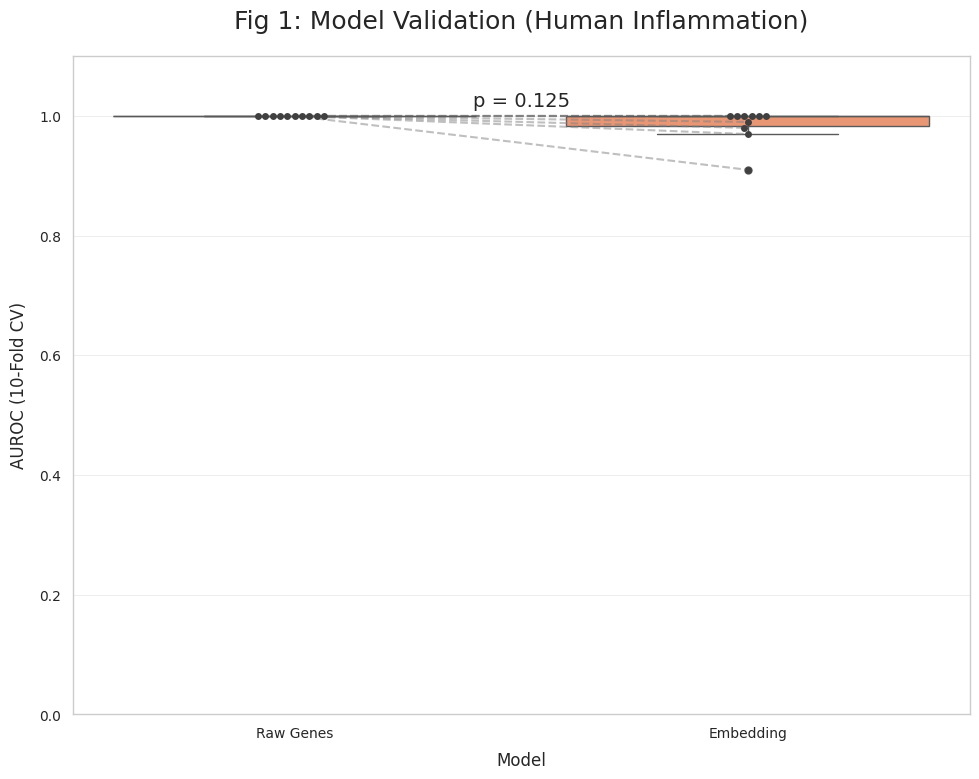

In [37]:
# Create a DataFrame for easy plotting with seaborn
df_list = []
for i in range(N_SPLITS):
    df_list.append({"fold": i, "AUROC": scores_raw[i], "Model": "Raw Genes"})
    df_list.append({"fold": i, "AUROC": scores_emb[i], "Model": "Embedding"})

results_df = pd.DataFrame(df_list)

# Plot
plt.figure(figsize=(10, 8))

# Boxplot
sns.boxplot(data=results_df, x="Model", y="AUROC", palette="Set2")

# Overlay swarmplot (the individual points)
sns.swarmplot(data=results_df, x="Model", y="AUROC", color="0.25")

# Draw the lines connecting paired folds
for i in range(N_SPLITS):
    fold_data = results_df[results_df["fold"] == i]
    plt.plot(fold_data["Model"], fold_data["AUROC"], color="gray", linestyle="--", alpha=0.5)

# Add annotations for p-values
y_max = results_df["AUROC"].max()
plt.text(0.5, y_max + 0.01, f"p = {p:.3f}", ha="center", va="bottom", fontsize=14)

plt.title("Fig 1: Model Validation (Human Inflammation)", fontsize=18, pad=20)
plt.ylabel("AUROC (10-Fold CV)")
plt.ylim(bottom=0, top=1.1)  # Adjust y-axis to make space
plt.tight_layout()

# Save the figure
# plt.savefig("figure_1_transferability.png", dpi=300)
plt.show()

In [38]:
human_sub = human_adata[~human_adata.obs["takao_status"].isna()]
datasets = human_sub.obs["dataset"]
unique_datasets = datasets.unique()

# Store results here
scores_raw = []
scores_emb = []
fold_names = []

for test_dataset in unique_datasets:
    print(f"--- FOLD: Holding out '{test_dataset}' ---")
    fold_names.append(test_dataset)

    # Create train/test masks
    test_mask = datasets == test_dataset
    train_mask = ~test_mask

    # --- Create Train/Test Splits ---
    # Raw Genes
    X_raw_train, X_raw_test = human_X[train_mask], human_X[test_mask]
    # Embeddings
    X_emb_train, X_emb_test = human_X_emb[train_mask], human_X_emb[test_mask]
    # Labels
    y_train, y_test = human_y[train_mask], human_y[test_mask]

    # --- Train and Score Raw ---
    pipeline_raw.fit(X_raw_train, y_train)
    y_pred_raw_nl = pipeline_raw.predict_proba(X_raw_test)[:, 1]
    scores_raw.append(roc_auc_score(y_test, y_pred_raw_nl))

    # --- Train and Score Embedding (Linear) ---
    pipeline_emb.fit(X_emb_train, y_train)
    y_pred_emb_lin = pipeline_emb.predict_proba(X_emb_test)[:, 1]
    scores_emb.append(roc_auc_score(y_test, y_pred_emb_lin))

print("\n--- LODO-CV Mean Scores ---")
print(f"Raw Genes AUROC:       {np.mean(scores_raw):.4f} +/- {np.std(scores_raw):.4f}")
print(f"Embedding AUROC:       {np.mean(scores_emb):.4f} +/- {np.std(scores_emb):.4f}")

--- FOLD: Holding out 'human_burn' ---


--- FOLD: Holding out 'human_sepsis' ---
--- FOLD: Holding out 'human_trauma' ---

--- LODO-CV Mean Scores ---
Raw Genes AUROC:       0.9962 +/- 0.0054
Embedding AUROC:       0.9778 +/- 0.0164


Information Preservation: p-value = 0.2500


/tmp/ipykernel_1865861/4023802032.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Model', y='AUROC', palette='Set2')


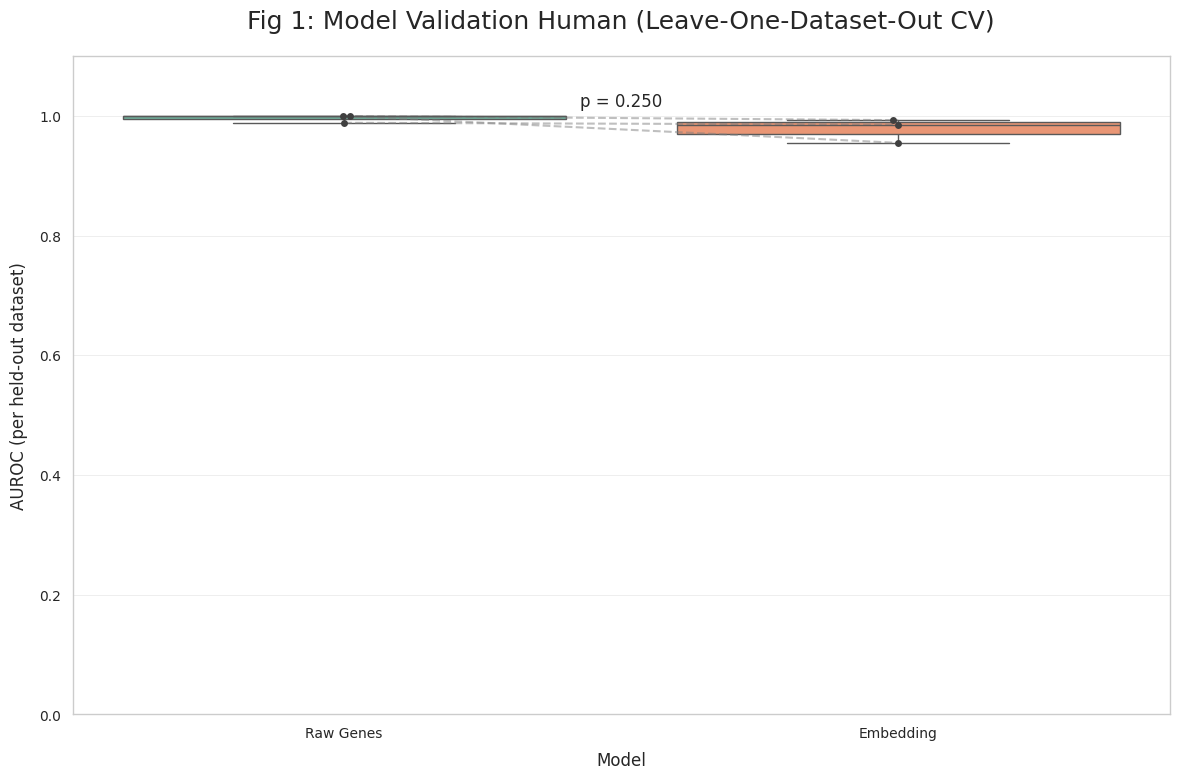

In [39]:
_, p = wilcoxon(scores_raw, scores_emb, alternative="two-sided")

print(f"Information Preservation: p-value = {p:.4f}")

# 2. Create DataFrame for plotting
df_list = []
for i, fold_name in enumerate(fold_names):
    df_list.append({"fold": fold_name, "AUROC": scores_raw[i], "Model": "Raw Genes"})
    df_list.append({"fold": fold_name, "AUROC": scores_emb[i], "Model": "Embedding"})

results_df = pd.DataFrame(df_list)

# 3. Plot
plt.figure(figsize=(12, 8))

# Boxplot
sns.boxplot(data=results_df, x="Model", y="AUROC", palette="Set2")
# Swarmplot
sns.swarmplot(data=results_df, x="Model", y="AUROC", color="0.25")

# Draw the lines connecting paired folds
for fold_name in fold_names:
    fold_data = results_df[results_df["fold"] == fold_name]
    plt.plot(fold_data["Model"], fold_data["AUROC"], color="gray", linestyle="--", alpha=0.5)

# Add annotations
y_max = results_df["AUROC"].max()
plt.text(0.5, y_max + 0.01, f"p = {p:.3f}", ha="center", va="bottom", fontsize=12)
plt.title("Fig 1: Model Validation Human (Leave-One-Dataset-Out CV)", fontsize=18, pad=20)
plt.ylabel("AUROC (per held-out dataset)")
plt.ylim(bottom=0, top=1.1)
plt.tight_layout()

plt.show()

### Quantify cross-species generalization

In [40]:
# constrain genes to those shared between human and mouse
common_genes = human_adata.var_names.intersection(mouse_adata.var_names)
human_adata = human_adata[:, common_genes]
mouse_adata = mouse_adata[:, common_genes]

# get X and y for human and mouse
human_X, human_X_emb, human_y = transform_adata_to_X_y(human_adata)
mouse_X, mouse_X_emb, mouse_y = transform_adata_to_X_y(mouse_adata)

print(
    human_X.shape,
    human_X_emb.shape,
    human_y.shape,
    mouse_X.shape,
    mouse_X_emb.shape,
    mouse_y.shape,
)

(200, 12693) (200, 640) (200,) (121, 12693) (121, 640) (121,)


In [41]:
results = {}

# --- Test A: Raw Genes (Human → Mouse) ---
print("Training Raw (Human)... Testing (Mouse)")
pipeline_raw.fit(human_X, human_y)
y_pred_A = pipeline_raw.predict_proba(mouse_X)[:, 1]
auroc_A = roc_auc_score(mouse_y, y_pred_A)
results["Raw Genes (Human → Mouse)"] = auroc_A

# --- Test B: Raw Genes (Mouse → Human) ---
print("Training Raw (Mouse)... Testing (Human)")
pipeline_raw.fit(mouse_X, mouse_y)
y_pred_B = pipeline_raw.predict_proba(human_X)[:, 1]
auroc_B = roc_auc_score(human_y, y_pred_B)
results["Raw Genes (Mouse → Human)"] = auroc_B

# --- Test C: Embeddings (Human → Mouse) ---
print("Training Embedding (Human)... Testing (Mouse)")
pipeline_emb.fit(human_X_emb, human_y)
y_pred_C = pipeline_emb.predict_proba(mouse_X_emb)[:, 1]
auroc_C = roc_auc_score(mouse_y, y_pred_C)
results["Embedding (Human → Mouse)"] = auroc_C

# --- Test D: Embeddings (Mouse → Human) ---
print("Training Embedding (Mouse)... Testing (Human)")
pipeline_emb.fit(mouse_X_emb, mouse_y)
y_pred_D = pipeline_emb.predict_proba(human_X_emb)[:, 1]
auroc_D = roc_auc_score(human_y, y_pred_D)
results["Embedding (Mouse → Human)"] = auroc_D

print("\n--- Results ---")
for k, v in results.items():
    print(f"{k}: AUROC = {v:.4f}")

Training Raw (Human)... Testing (Mouse)


Training Raw (Mouse)... Testing (Human)
Training Embedding (Human)... Testing (Mouse)
Training Embedding (Mouse)... Testing (Human)

--- Results ---
Raw Genes (Human → Mouse): AUROC = 0.7186
Raw Genes (Mouse → Human): AUROC = 0.9785
Embedding (Human → Mouse): AUROC = 0.7445
Embedding (Mouse → Human): AUROC = 0.6824


/tmp/ipykernel_1865861/2025015590.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_df['Direction'], rotation=0, fontsize=12) # Use direction as label


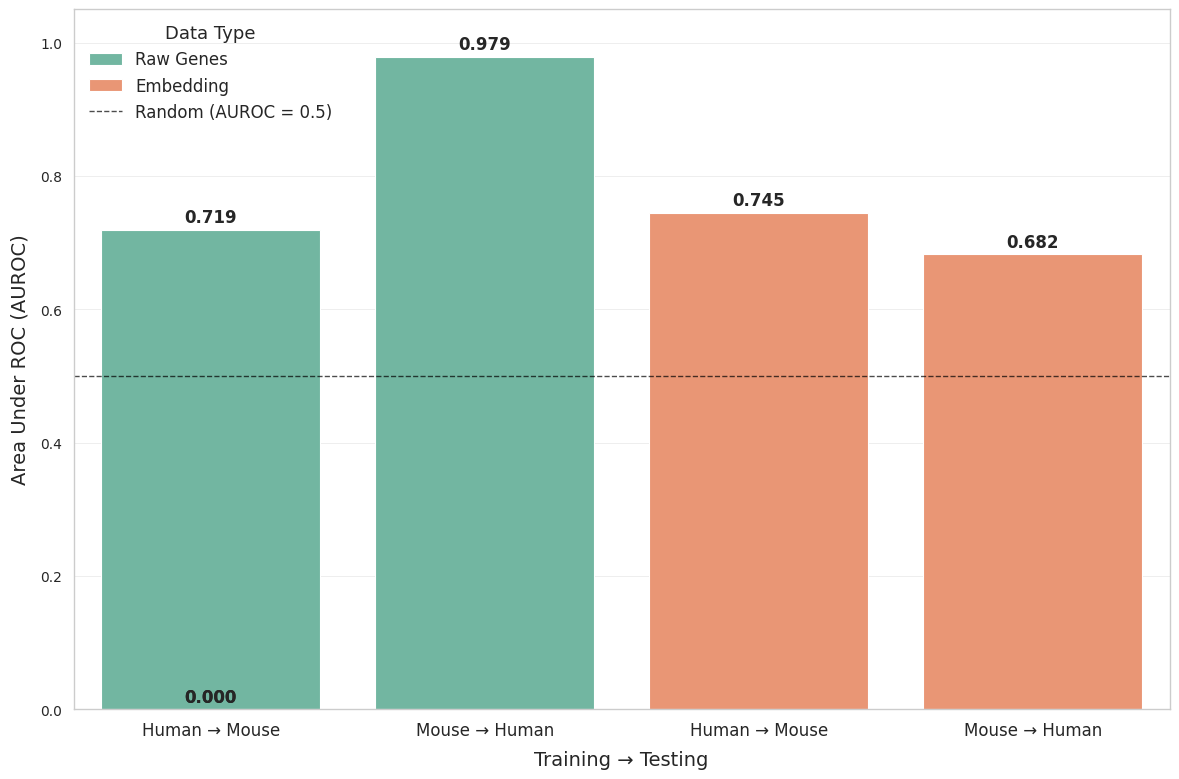

In [42]:
# Convert results dictionary to a DataFrame for plotting
results_df = pd.DataFrame(list(results.items()), columns=["Experiment", "AUROC"])

# Add columns for plot grouping
results_df["Data Type"] = results_df["Experiment"].apply(
    lambda x: "Raw Genes" if "Raw Genes" in x else "Embedding"
)
results_df["Direction"] = results_df["Experiment"].apply(
    lambda x: x.split("(")[1].replace(")", "")
)

plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(
    data=results_df, x="Experiment", y="AUROC", hue="Data Type", palette="Set2", dodge=False
)

# Add a dashed line for random chance
ax.axhline(0.5, ls="--", color="black", lw=1, alpha=0.7, label="Random (AUROC = 0.5)")

# Aesthetics
ax.set_ylabel("Area Under ROC (AUROC)", fontsize=14)
ax.set_xlabel("Training → Testing", fontsize=14)
ax.set_xticklabels(results_df["Direction"], rotation=0, fontsize=12)  # Use direction as label
ax.legend(title="Data Type", loc="upper left", fontsize=12, title_fontsize=13)

# Set Y-axis limit to go from 0 to 1
ax.set_ylim(0, 1.05)

# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
        fontsize=12,
        fontweight="bold",
    )

plt.tight_layout()
# plt.savefig("figure_2_cross_species_generalization.png", dpi=300)
plt.show()

My interpretation: We have an implicit assumption since we map mouse data to orthologs, then further restrict to the intersection of human and mouse genes for the raw data. This is likely capturing the core inflammation program

* You pre-selected for conservation. You only gave the model the genes that are, by definition, conserved between mice and humans.
* You threw away the noise. You removed the approx 7,000$ human-specific genes and all the mouse-specific genes. These are the exact genes that cause the Seok (2013) decorrelation in the first place.
* The 0.974 (Mouse to Human) Score: This is the result of training a model on the "conserved core" of the mouse response and applying it to the "conserved core" of the human response. It's not surprising it works; we basically forced it to.

Training Raw (Human)...
Training Raw (Mouse)...
Training Embedding (Human)...
Training Embedding (Mouse)...
Calculating alignment...
Raw Gene Classifier Alignment (Cosine Sim): 0.0746
Embedding Classifier Alignment (Cosine Sim): -0.0233


/tmp/ipykernel_1865861/1402340301.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_1865861/1402340301.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)


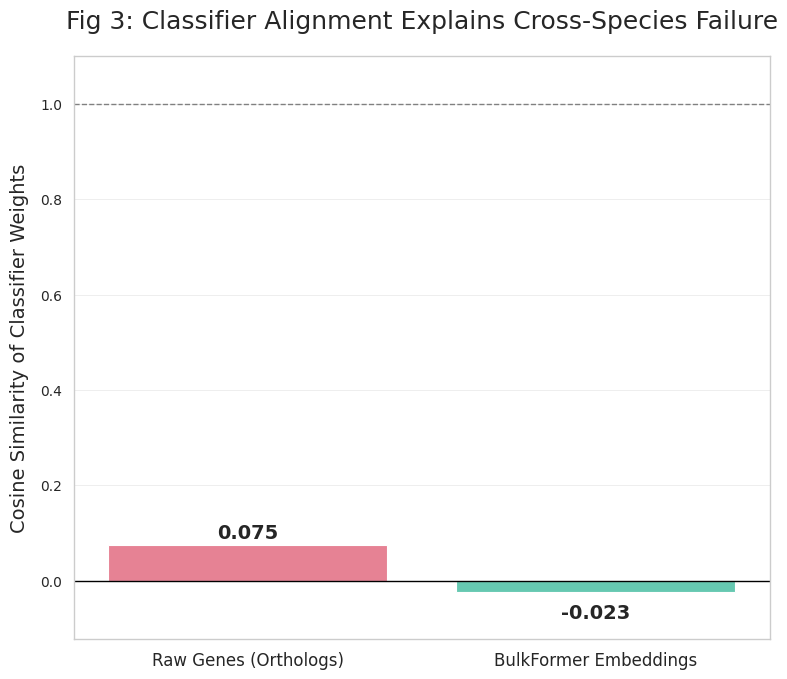

Script Complete.


In [45]:
# Train on Human raw genes
print("Training Raw (Human)...")
model_raw_human = pipeline_raw.fit(human_X, human_y)
W_raw_human = model_raw_human.named_steps["clf"].coef_

# Train on Mouse raw genes
print("Training Raw (Mouse)...")
model_raw_mouse = pipeline_raw.fit(mouse_X, mouse_y)
W_raw_mouse = model_raw_mouse.named_steps["clf"].coef_

# --- Step 2: Train Classifiers on Embeddings ---
# Train on Human embeddings
print("Training Embedding (Human)...")
model_emb_human = pipeline_emb.fit(human_X_emb, human_y)
W_emb_human = model_emb_human.named_steps["clf"].coef_

# Train on Mouse embeddings
print("Training Embedding (Mouse)...")
model_emb_mouse = pipeline_emb.fit(mouse_X_emb, mouse_y)
W_emb_mouse = model_emb_mouse.named_steps["clf"].coef_

# --- Step 3: Compare Classifier Logic (Cosine Similarity) ---

print("Calculating alignment...")
sim_raw = cosine_similarity(W_raw_human, W_raw_mouse)[0][0]
sim_emb = cosine_similarity(W_emb_human, W_emb_mouse)[0][0]

print(f"Raw Gene Classifier Alignment (Cosine Sim): {sim_raw:.4f}")
print(f"Embedding Classifier Alignment (Cosine Sim): {sim_emb:.4f}")

# --- Step 4: Plot the Figure 3 Bar Chart ---

# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Model Type": ["Raw Genes (Orthologs)", "BulkFormer Embeddings"],
        "Cosine Similarity": [sim_raw, sim_emb],
    }
)

plt.figure(figsize=(8, 7))
ax = sns.barplot(
    data=plot_data, x="Model Type", y="Cosine Similarity", palette=["#f77189", "#56d8b9"]
)

# Add a horizontal line at 0 for reference
ax.axhline(0, ls="-", color="black", lw=1)
# Add a dashed line at 1 (perfect alignment)
ax.axhline(1.0, ls="--", color="grey", lw=1)

# Aesthetics
ax.set_title("Fig 3: Classifier Alignment Explains Cross-Species Failure", fontsize=18, pad=20)
ax.set_ylabel("Cosine Similarity of Classifier Weights", fontsize=14)
ax.set_xlabel("", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

# Set Y-axis limit
y_min = min(0, sim_raw, sim_emb) - 0.1
y_max = max(1, sim_raw, sim_emb) + 0.1
ax.set_ylim(y_min, y_max)

# Annotate the bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9 if p.get_height() > 0 else -15),
        textcoords="offset points",
        fontsize=14,
        fontweight="bold",
    )

plt.tight_layout()
# plt.savefig("figure_3_classifier_alignment.png", dpi=300)
plt.show()

print("Script Complete.")

In [50]:
# print top features from raw gene classifiers
feature_names = common_genes.tolist()
coef_raw_human = model_raw_human.named_steps["clf"].coef_[0]
coef_raw_mouse = model_raw_mouse.named_steps["clf"].coef_[0]

# Create DataFrames for easy sorting and display
df_human = pd.DataFrame({"Gene": feature_names, "Coefficient": coef_raw_human}).sort_values(
    by="Coefficient", ascending=False
)

df_mouse = pd.DataFrame({"Gene": feature_names, "Coefficient": coef_raw_mouse}).sort_values(
    by="Coefficient", ascending=False
)
print("\nTop 10 Features from Human Raw Gene Classifier:")
print(df_human.head(30).to_string(index=False))


Top 10 Features from Human Raw Gene Classifier:
           Gene  Coefficient
ENSG00000127954     0.064250
ENSG00000175130     0.058935
ENSG00000148346     0.055863
ENSG00000163220     0.055561
ENSG00000130638     0.053611
ENSG00000163421     0.053347
ENSG00000136167     0.049737
ENSG00000139572     0.049579
ENSG00000167780     0.047695
ENSG00000046647     0.046812
ENSG00000170011     0.046443
ENSG00000183696     0.046033
ENSG00000068650     0.045961
ENSG00000167779     0.045748
ENSG00000125675     0.045116
ENSG00000198959     0.044590
ENSG00000105835     0.044067
ENSG00000118785     0.043624
ENSG00000145287     0.043254
ENSG00000277443     0.042433
ENSG00000133048     0.042140
ENSG00000143546     0.041742
ENSG00000165621     0.041111
ENSG00000104140     0.040880
ENSG00000157693     0.040038
ENSG00000184557     0.040014
ENSG00000089159     0.039762
ENSG00000156711     0.039682
ENSG00000144802     0.039035
ENSG00000102794     0.038867


In [51]:
print("\nTop 10 Features from Mouse Raw Gene Classifier:")
print(df_mouse.head(30).to_string(index=False))


Top 10 Features from Mouse Raw Gene Classifier:
           Gene  Coefficient
ENSG00000127954     0.064250
ENSG00000175130     0.058935
ENSG00000148346     0.055863
ENSG00000163220     0.055561
ENSG00000130638     0.053611
ENSG00000163421     0.053347
ENSG00000136167     0.049737
ENSG00000139572     0.049579
ENSG00000167780     0.047695
ENSG00000046647     0.046812
ENSG00000170011     0.046443
ENSG00000183696     0.046033
ENSG00000068650     0.045961
ENSG00000167779     0.045748
ENSG00000125675     0.045116
ENSG00000198959     0.044590
ENSG00000105835     0.044067
ENSG00000118785     0.043624
ENSG00000145287     0.043254
ENSG00000277443     0.042433
ENSG00000133048     0.042140
ENSG00000143546     0.041742
ENSG00000165621     0.041111
ENSG00000104140     0.040880
ENSG00000157693     0.040038
ENSG00000184557     0.040014
ENSG00000089159     0.039762
ENSG00000156711     0.039682
ENSG00000144802     0.039035
ENSG00000102794     0.038867
